# Assignment 3

Repeat the steps in notebook *09-Classification/02-Logistic-Regression-Example.ipynb* but with this new dataset. The data is located in *data/Telco-Customer-Churn.csv*. Report your best model with its AUC on test and train.

First part which is data importing and cleaning has been done for you.

## Customer Churn

Also known as customer attrition, or customer turnover is the loss of clients or customers. Customer churn is a critical metric because it is much less expensive to retain existing customers than it is to acquire new ones. 

Companies usually make a distinction between voluntary churn and involuntary churn. In most analyses involuntary churn is excluded. 

Predictive analytics uses machine learning to predict the likelihood of a customer churning. These models will identify a small subgroup of potential customers that are at a higher risk of abandoning the company. This empowers the company to focus on the subset of the customers who are most likely to churn and through customer retention marketing programs stop some of that to happen.


## Data

**Telco Customer Churn**

The data was downloaded from IBM Sample Data Sets (now on Kaggle): https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Each row represents a customer, each column contains customer's attributes described as below:

* **customerID**: Customer ID
* **gender**: Customer gender (female, male)
* **SeniorCitizen**: Whether the customer is a senior citizen or not (1, 0)
* **Partner**: Whether the customer has a partner or not (Yes, No)
* **Dependents**: Whether the customer has dependents or not (Yes, No)
* **tenure**: Number of months the customer has stayed with the company
* **PhoneService**: Whether the customer has a phone service or not (Yes, No)
* **MultipleLines**: Whether the customer has multiple lines or not (Yes, No, No phone service)
* **InternetService**: Customer's internet service provider (DSL, Fiber optic, No)
* **OnlineSecurity**: Whether the customer has online security or not (Yes, No, No internet service)
* **OnlineBackup**: Whether the customer has online backup or not (Yes, No, No internet service)
* **DeviceProtection**: Whether the customer has device protection or not (Yes, No, No internet service)
* **TechSupport**: Whether the customer has tech support or not (Yes, No, No internet service)
* **StreamingTV**: Whether the customer has streaming TV or not (Yes, No, No internet service)
* **StreamingMovies**: Whether the customer has streaming movies or not (Yes, No, No internet service)
* **Contract**: The contract term of the customer (Month-to-month, One year, Two year)
* **PaperlessBilling**: Whether the customer has paperless billing or not (Yes, No)
* **PaymentMethod**: The customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* **MonthlyCharges**: The amount charged to the customer monthly
* **TotalCharges**: The total amount charged to the customer
* **Churn**: Whether the customer churned or not (Yes or No)

The data set includes information about:

* Customers who left - the column is called `Churn`
* Services that each customer has signed up for - phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information - how long they've been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers - gender, age range, and if they have partners and dependents

Importing libraries:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import *

# the following line gets the bucket name attached to our cluster
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

# specifying the path to our bucket where the data is located (no need to edit this path anymore)
data = "gs://" + bucket + "/notebooks/jupyter/data/"
print(data)

gs://pstat135-bh/notebooks/jupyter/data/


Get the data from here: https://github.com/UCSB-PSTAT-135-235/Winter2023/blob/public/01-Introduction/data/Telco-Customer-Churn.csv

Importing data:

In [2]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferschema", True)\
  .load(data + "Telco-Customer-Churn.csv")\
  .coalesce(5)

df = df.drop('customerID')  # Dropping customerID
df.cache()
df.show(5)
df.printSchema()
print("This datasets consists of {} rows.".format(df.count()))
df = df.withColumn("TotalCharges",df.TotalCharges.cast('double'))
df = df.withColumn("SeniorCitizen",df.SeniorCitizen.cast('string'))


+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|         No|             No|Month-to-month|     

Checking for missing values:

In [3]:
[(c, df.where(col(c).isNull()).count()) for c in df.columns]


[('gender', 0),
 ('SeniorCitizen', 0),
 ('Partner', 0),
 ('Dependents', 0),
 ('tenure', 0),
 ('PhoneService', 0),
 ('MultipleLines', 0),
 ('InternetService', 0),
 ('OnlineSecurity', 0),
 ('OnlineBackup', 0),
 ('DeviceProtection', 0),
 ('TechSupport', 0),
 ('StreamingTV', 0),
 ('StreamingMovies', 0),
 ('Contract', 0),
 ('PaperlessBilling', 0),
 ('PaymentMethod', 0),
 ('MonthlyCharges', 0),
 ('TotalCharges', 11),
 ('Churn', 0)]

There are 11 missing values in `TotalCharges`. Let's fill them with 0 since they seem to be new customers:

In [4]:
df = df.fillna(0)

Define an RFormula that uses all of the columns as features and call it `supervised`:

In [5]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="Churn ~ .")


Fit the RFormula transformer and call it `fittedRF`:

In [6]:
fittedRF = supervised.fit(df)

Using `fittedRF` transform our `df` DataFrame. Call this `preparedDF`:

In [7]:
preparedDF = fittedRF.transform(df)

Print the first couple of rows of `preparedDF`, with the truncate option off:

In [8]:
preparedDF.show(2, truncate = False)


23/03/09 03:05:39 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+-----------------------------------------------------------------------------------------------------------------------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod   |MonthlyCharges|TotalCharges|Churn|features                                                                                                                     |label|
+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------

Below we will retrieve the name of the columns used to make our feature vector and store them in a pandas DataFrame:

In [9]:
colsDF = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"] 
["attrs"]["binary"]+preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

colsDF

,idx,name
0,0,gender_Male
1,1,SeniorCitizen_0
2,2,Partner_No
3,3,Dependents_No
27,4,tenure
4,5,PhoneService_Yes
5,6,MultipleLines_No
6,7,MultipleLines_Yes
7,8,InternetService_Fiber optic
8,9,InternetService_DSL


Split the transformed data into `train` and `test`. Use a 30% split and a `seed`.

In [10]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 619)

Instantiate an instance of `LogisticRegression`. Call it `lr`:

In [11]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label",featuresCol="features")

Print the parameters of `lr` to check the default values used. You can always come back to the cell above and change the default values:

In [12]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

Fit the model on `train` and call it `lrModel`:

In [13]:
lrModel = lr.fit(train)

23/03/09 03:05:44 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/09 03:05:44 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Below we plot the coefficients of our model in a sorted fashion:

In [14]:
print(lrModel.coefficients)

[-0.006317193085420403,-0.22391539761895196,-0.11150004711828043,0.14838303743599532,-0.05032550719237235,0.6625393598964171,-0.12424435399940957,0.36025273386968165,1.7713347474814123,-0.6238823325888405,0.6770067753475344,0.6195900372916535,0.5937535122336697,0.6570629009164786,0.5258667927640625,0.7347744106555666,0.6372243560704174,0.6652644266925237,0.19469014069090027,1.048151635946414,0.1976691876996898,1.041581517044071,0.6641001433758386,-0.7713153683769945,0.3691188639476932,0.4460302236410799,0.14979335556202233,0.18977358612827142,-0.060505701261060224,0.00021745358605826175]


In [15]:
print(lrModel.intercept)

-1.3066519609336011


### Feature importance

We already retrieved the name of the features. Let's join it with the coefficients to identify the ones with bigger absolute value:

In [16]:
array = np.array(lrModel.coefficients)
coefficients = pd.DataFrame(array, columns = ['coefficient'])

merged = colsDF.merge(coefficients, left_index = True, right_index = True)

merged.reindex(merged['coefficient'].abs().sort_values(ascending=False).index)


,idx,name,coefficient
8,9,InternetService_DSL,1.771335
19,20,StreamingMovies_No,1.048152
21,22,Contract_Month-to-month,1.041582
23,24,PaperlessBilling_Yes,-0.771315
15,16,TechSupport_No,0.734774
10,11,OnlineSecurity_Yes,0.677007
17,18,StreamingTV_No,0.665264
22,23,Contract_Two year,0.664100
5,6,MultipleLines_No,0.662539
13,14,DeviceProtection_No,0.657063


Plot a bar chart:

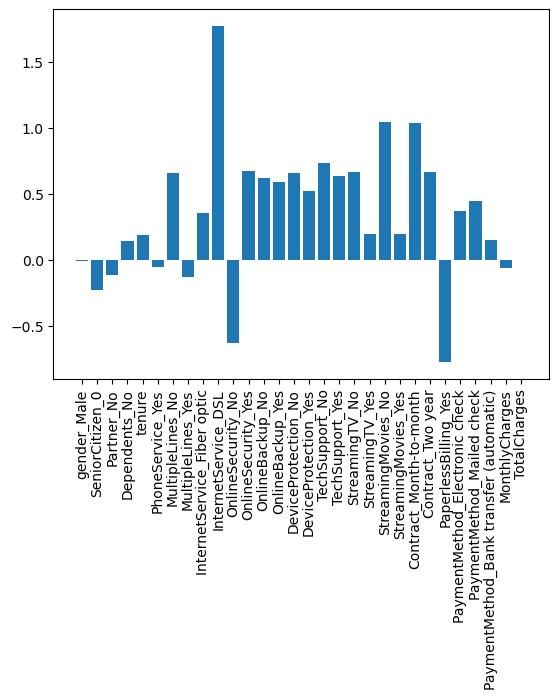

In [17]:
plt.bar(merged['name'], merged['coefficient'])
plt.xticks(rotation='vertical')
plt.show()

From our fitted model, `lrModel`, extract the summary and call it `summary`:

In [18]:
summary = lrModel.summary


From `summary` extract `areaUnderROC`. Note that this AUC is from the `train` dataset and we should pay more attention to the AUC coming from the `test` set:

In [19]:
summary.areaUnderROC


0.8460341850268617

From `summary` extract `roc` and convert it to a pandas DataFrame. Call it `roc`:

In [20]:
roc = summary.roc.toPandas()
roc

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.002990
2,0.000000,0.005979
3,0.000278,0.008221
4,0.000835,0.009716
...,...,...
1224,0.996939,1.000000
1225,0.998052,1.000000
1226,0.999165,1.000000
1227,1.000000,1.000000


Visualize the `roc` DataFrame:

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt


Text(0, 0.5, 'TPR')

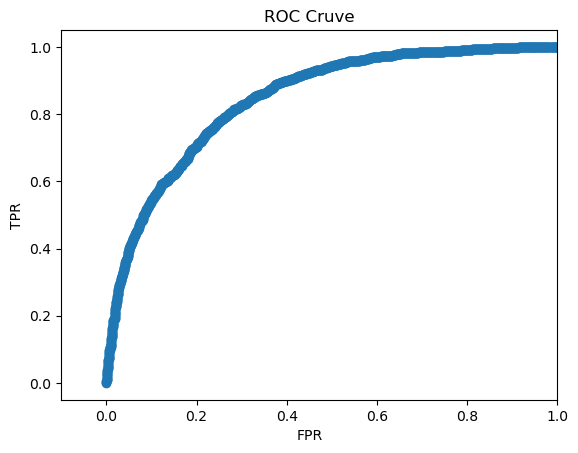

In [22]:

roc.plot(x='FPR', y='TPR', xlim = [-0.1, 1], style='--o', legend=False)
plt.title('ROC Cruve')
plt.ylabel('TPR')

Do the same with `pr` from `summary`:

Text(0, 0.5, 'precision')

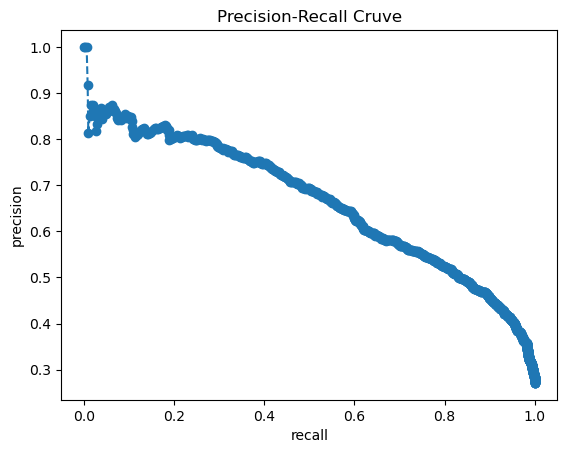

In [23]:
pr = summary.pr.toPandas()

pr.plot(x='recall', y='precision', style='--o', legend=False)
plt.title('Precision-Recall Cruve')
plt.ylabel('precision')

Our baseline model looks promising. Let's do some predictions on the `test` set.

Pass the `test` set through our trained model. Called the resulting DataFrame `fittedTest`:

In [24]:
fittedTest = lrModel.transform(test)

Print the first few rows of this DataFrame. Only show the following columns: "label", "prediction", "rawPrediction"

In [25]:
fittedTest.select(['label', 'prediction', 'rawPrediction']).show(4)


+-----+----------+--------------------+
|label|prediction|       rawPrediction|
+-----+----------+--------------------+
|  1.0|       1.0|[-0.2030213040636...|
|  1.0|       1.0|[-0.8990270886877...|
|  1.0|       1.0|[-0.8357244286290...|
|  0.0|       0.0|[0.34155384012111...|
+-----+----------+--------------------+
only showing top 4 rows



Make an evaluator from `BinaryClassificationEvaluator` function that calculates AUC. We will use this function to measure our model's performance on the `test` set. Call this evaluator `aucEvaluator`. 

Note that this function can be found under the `pyspark.ml.evaluation` module.

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
aucEvaluator = BinaryClassificationEvaluator(metricName = 'areaUnderROC')


Using our `aucEvaluator` find out the AUC on the `test` set:

In [27]:
aucEvaluator.evaluate(fittedTest)

0.8510184986531245

Are your test and train AUC's within the same range?

Answer: Yes, my test and train AUC's are within the same range. In fact, the AUC for the test data was actually slightly higher!

### (PSTAT 234) Adding regularization

Add elastic net regularization following the hyperparameter gridsearch example in the textbook. Instead of `TrainValidationSplit`, use [`CrossValidator`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html?highlight=crossvalidator). Tune two parameters `regParam` and `elasticNetParam`.

Choose two grids (one for each parameters). Create a pipeline to tune your model with 5-fold cross-validation.